In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

In [2]:

class LightViT(nn.Module):
    def __init__(self, image_dim, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10):
        super(LightViT, self).__init__()

        ## Class Members
        self.image_dim = image_dim
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.d = d
        self.n_heads = n_heads
        self.num_classes = num_classes
    
        
        ## 1B) Linear Mapping
        self.linear_map = LinearMap(self.image_dim, self.n_patches, self.d);
        
        ## 2A) Learnable Parameter
        self.cls_token = nn.Parameter(torch.randn(1,1, self.d));
        
        ## 2B) Positional embedding
        ## 3) Encoder blocks
        self.encoders = ViTEncoder(self.d, self.n_heads);
        
        # 5) Classification Head
        self.classifier = nn.Linear(self.d, self.num_classes);
    

    def forward(self, images):
        ## Extract patches
        patch = patches(images, self.n_patches)
        
        ## Linear Mapping
        linear_mappings = self.linear_map(patch)
        
        ## Add class token
        b = images.shape[0]
        cls_tokens = self.cls_token.expand(b,-1,-1).to(images.device)
        tokens = torch.cat((cls_tokens, linear_mappings), dim=1)

        ## Add positional embeddings
        pos_embed = get_pos_embeddings(tokens, self.d).to(images.device)
        input_embed = tokens + pos_embed

        ## Pass through encoder
        encoder_out = self.encoders(input_embed)

        ## Get classification token
        output = encoder_out[:,0:1,:]
        class_token = output.squeeze()
        
        ## Pass through classifier
        final_out = self.classifier(class_token)

        return final_out

In [3]:
def patches(images, patch_size):
    B,C,H,W = images.shape
    out = images.unfold(2,patch_size,patch_size).unfold(3,patch_size,patch_size)
    out = out.contiguous().view(B,-1,patch_size*patch_size)
    out = out.permute(0,2,1)
    #print(out.shape)
    return out

In [4]:
class LinearMap(nn.Module):
    def __init__(self,img_dim, n_patches, d):
        super().__init__()
        self.linear = nn.Linear((img_dim[2]//n_patches)**2, d)

    def forward(self, x):
        x = self.linear(x)
        #print(x.shape)
        return x

In [5]:
def get_pos_embeddings(tokens, d):
    b = tokens.shape[0]
    len = tokens.shape[1]
    pos = torch.arange(0, len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d, 2).float()*(-math.log(10000.0) /d))
    pe = torch.zeros(len, d)
    pe[:, 0::2] = torch.sin(pos*div_term)
    pe[:, 1::2] = torch.cos(pos*div_term)
    pe = pe.unsqueeze(0)
    pe = pe.expand(b,-1,-1)
    return pe

In [6]:
class MHSA(nn.Module):
    def __init__(self,d=8, n_heads=2): # d: dimension of embedding spacr, n_head: dimension of attention heads
        super(MHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        self.d_per_head = d//n_heads #dimension of each head

        self.q = nn.Linear(d,d)
        self.k = nn.Linear(d,d)
        self.v = nn.Linear(d,d)
        self.proj = nn.Linear(d,d)
        
    def forward(self,sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # Shape is transformed to   (N, seq_length, n_heads, token_dim / n_heads)
        # And finally we return back    (N, seq_length, item_dim)  (through concatenation)
        b,l,_ = sequences.shape
        
        queries = self.q(sequences) 
        keys = self.k(sequences)
        values = self.v(sequences)
        
        queries = queries.view(b, l, self.n_heads, self.d_per_head)
        keys = keys.view(b, l, self.n_heads, self.d_per_head)
        values = values.view(b, l, self.n_heads, self.d_per_head)

        scores = torch.matmul(queries.transpose(2,3), keys)/math.sqrt(self.d_per_head)
        attention = nn.functional.softmax(scores, dim=1)

        out = torch.matmul(attention, values.transpose(2,3))
        out = out.transpose(2,3).contiguous()
        out = out.view(b, l, -1)
        out = self.proj(out)
        return out

In [7]:
class ViTEncoder(nn.Module):
    def __init__(self, hidden_d, n_heads):
        super(ViTEncoder, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d) # Add Layer-Norm
        self.mhsa = MHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d) # Add another Layer-Norm
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, 4 * hidden_d),
            nn.GELU(),
            nn.Linear(4 * hidden_d, hidden_d)
        )


    def forward(self, x):
        out = self.mhsa.forward(self.norm1(x)) + x #Residual connection here
        out = out + self.mlp(self.norm2(out))
        return out

In [8]:
if __name__ == '__main__':
  model = ViTEncoder(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  
  print(model(x).shape)

torch.Size([7, 50, 8])


In [9]:
## Define Dataloader

def load_mnist():
    transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    ])

    mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader_train = DataLoader(mnist_train_set, batch_size=64)

    mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    dataloader_test = DataLoader(mnist_test_set, batch_size=64)

    return dataloader_train, dataloader_test

mnist_train, mnist_test = load_mnist()

for img,label in mnist_train:
    image_dim = img.shape
    break

## Define Model
my_vis_transformer = LightViT(image_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_vis_transformer.to(device)

## Define Optimizer 
optimizer = torch.optim.Adam(my_vis_transformer.parameters(), lr=0.005)

## Define Loss
ce_loss = nn.CrossEntropyLoss().to(device)



In [10]:
num_epochs = 5
train_losses = []
test_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    my_vis_transformer.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in mnist_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = my_vis_transformer(images)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        _, predicted =torch.max(outputs.data, 1)
        total_train +=labels.size(0)
        correct_train +=(predicted ==labels).sum().item()
    train_loss =running_loss/len(mnist_train)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    ##Test
    
    my_vis_transformer.eval()
    correct=0
    total=0
    with torch.no_grad():
        for images, labels in mnist_test:
            images, labels = images.to(device), labels.to(device)
            outputs = my_vis_transformer(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy =100*correct/total
    test_accuracies.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/5], Loss: 1.2293, Train Accuracy: 55.31%
Test Accuracy: 66.22%
Epoch [2/5], Loss: 0.7645, Train Accuracy: 74.55%
Test Accuracy: 76.63%
Epoch [3/5], Loss: 0.6147, Train Accuracy: 79.80%
Test Accuracy: 80.20%
Epoch [4/5], Loss: 0.5529, Train Accuracy: 81.81%
Test Accuracy: 81.55%
Epoch [5/5], Loss: 0.5149, Train Accuracy: 83.14%
Test Accuracy: 81.93%


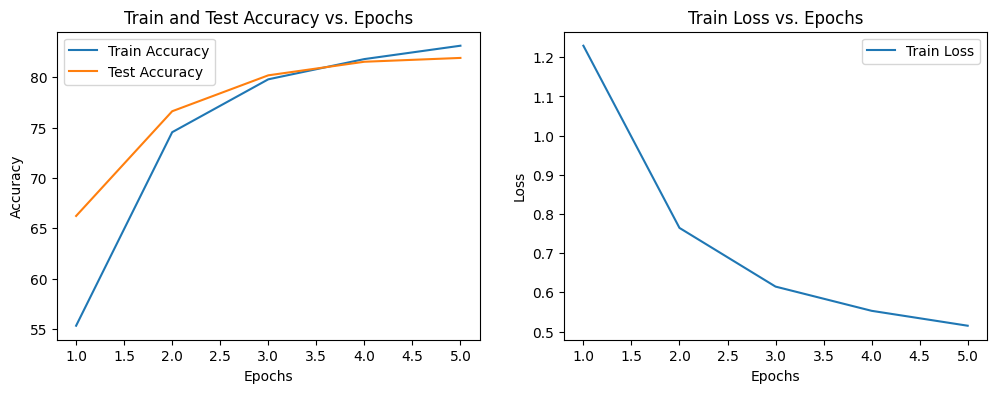

In [11]:
epochs = range(1,num_epochs+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracies, label='Train Accuracy')
plt.plot(epochs,test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_losses,label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epochs')
plt.legend()
plt.show()
